In [1]:
import urllib, json, objectpath
from pprint import pprint

In [2]:
def get_data(route):
    response = urllib.urlopen('http://pendlr.risc-software.at/log?id=["%s"]&num=10000' % route)
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..entries'))
def get_route():
    response = urllib.urlopen('http://pendlr.risc-software.at/log?num=10000')
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..id'))

The methods above will return json files with the relevent inforamtion, the routes names and the corresponding json.

Todo:
* Get the direction and see which route in close to another
* Merge the current traffic data with the weather data 
* make correlations between weather and traffic

In [3]:
routes = get_route()
cur_data   = {}

for r in routes :
    if 'cur.' in r:
        print "-- route : ", r
        cur_data[r] = get_data(r)

-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.traun.b1.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.auswaerts.bindermichl.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.auswa

In [4]:
pprint(cur_data['cur.urfahr.b127.traffic.risc-software.at'  ][0])
pprint(cur_data['cur.rohrbach.b127.traffic.risc-software.at'][0])
pprint("---------------------")
pprint(cur_data['cur.wilhering.b129.traffic.risc-software.at' ][0])
pprint(cur_data['cur.zentrum.b129.traffic.risc-software.at'   ][0])

{u'data': {u'attrs': {u'average_speed': 57.6,
                      u'delay': 6,
                      u'delayed_average_speed': 57.6,
                      u'distance': [10002],
                      u'duration': [615],
                      u'duration_in_traffic': [621],
                      u'total_distance': 10002,
                      u'total_duration': 615,
                      u'total_duration_in_traffic': 621},
           u'nip': u'10.32.5.17',
           u'o_id': u'cur.urfahr.b127.traffic.risc-software.at'},
 u'latency': 111,
 u'ts': 1482327007429}
{u'data': {u'attrs': {u'average_speed': 57.6,
                      u'delay': 44,
                      u'delayed_average_speed': 50.4,
                      u'distance': [9988],
                      u'duration': [624],
                      u'duration_in_traffic': [668],
                      u'total_distance': 9988,
                      u'total_duration': 624,
                      u'total_duration_in_traffic': 668},
        

From these output, we can see that that the usefull features would be the following:

```json
{u'attrs': {
      'average_speed'            : 39.6,
      'delay'                    : 8,
      'delayed_average_speed'    : 39.6,
      'total_distance'           : 4084,
      'total_duration'           : 359,
      'total_duration_in_traffic': 367
      }
}
```

For example the `total_duration` and `duration` are shown be on the same values. So one question rises, why `duration` here is a list and why it has the same value as the total one. 

In [5]:
import pandas as pd 
from pandas.io.json import json_normalize

In [6]:
cur_df = {}
for c in cur_data:
    print '-- route : ', c
    cur_df[c] = json_normalize(cur_data[c])

-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.auswaerts.bindermichl.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cu

After the normalisation of the json file, to make it easy to read, someone can use one root to extract the all the available features. But earlier we showed the most interetsing features so we are going to take those as the feature that we want to analyse

In [17]:
features =  [
    'ts',
    'data.attrs.delay'                    ,
    'data.attrs.average_speed'            ,
    'data.attrs.delayed_average_speed'    ,
    'data.attrs.total_distance'           ,
    'data.attrs.total_duration'           ,
    'data.attrs.total_duration_in_traffic'
]

### Running an example on just one route

let selection the `b129` root one of busiest route,

In [18]:
import numpy as np
print " number of features :: ", len(features)
X  = np.concatenate((cur_df['cur.wilhering.b129.traffic.risc-software.at'][features], 
                     cur_df['cur.zentrum.b129.traffic.risc-software.at'  ][features]))

Y  = np.concatenate((+np.ones(cur_df['cur.wilhering.b129.traffic.risc-software.at'].shape[0]), 
                     -np.ones(cur_df['cur.zentrum.b129.traffic.risc-software.at'  ].shape[0])))

df = pd.DataFrame(np.hstack((X, Y.reshape(Y.shape[0], -1))), columns = features + ['direction'])
df.head()

 number of features ::  7


,ts,data.attrs.delay,data.attrs.average_speed,data.attrs.delayed_average_speed,data.attrs.total_distance,data.attrs.total_duration,data.attrs.total_duration_in_traffic,direction
0,1.482327e+12,0.0,39.6,43.2,4316.0,362.0,356.0,1.0
1,1.482328e+12,0.0,39.6,43.2,4316.0,362.0,359.0,1.0
2,1.482328e+12,0.0,39.6,39.6,4316.0,362.0,361.0,1.0
3,1.482328e+12,0.0,39.6,43.2,4316.0,362.0,355.0,1.0
4,1.482329e+12,0.0,39.6,43.2,4316.0,362.0,358.0,1.0


In [19]:
df['date'] = pd.to_datetime(df['ts']/1000.0, unit='s')

In [20]:
import time
from dateutil import parser, rrule
from datetime import datetime, time, date

df['day'] = df['date'].apply(lambda x: x.date())
df['tod'] = df['date'].apply(lambda x: x.time())
df['dow'] = df['date'].apply(lambda x: x.weekday())    
df['hod'] = df['tod' ].apply(lambda x: x.hour)

# Is each time stamp on a working day (Mon-Fri)
df['working_day'] = (df['dow'] >= 0) & (df['dow'] <= 4)
 
# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
df['morning'] = (df['tod'] >= time( 6, 0)) & (df['tod'] <= time( 9,0))
df['evening'] = (df['tod'] >= time(15, 0)) & (df['tod'] <= time(18,0))

Let create a calendar vosualtion of the average delay

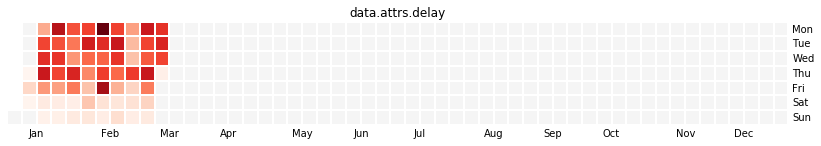

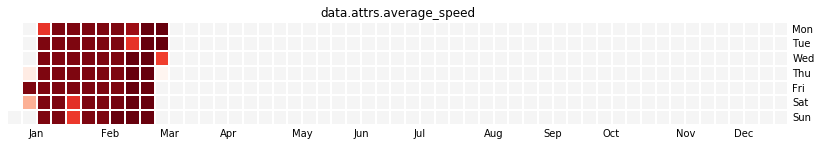

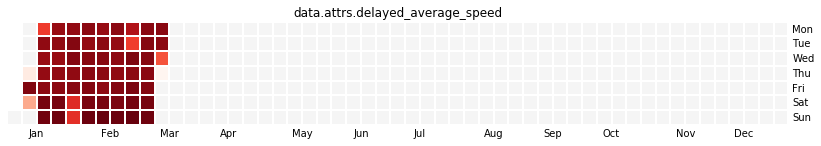

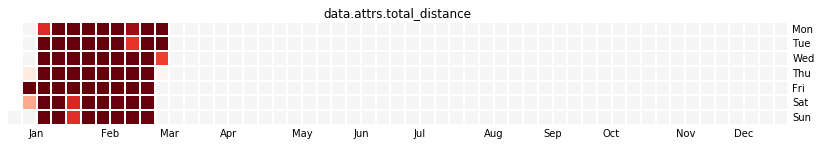

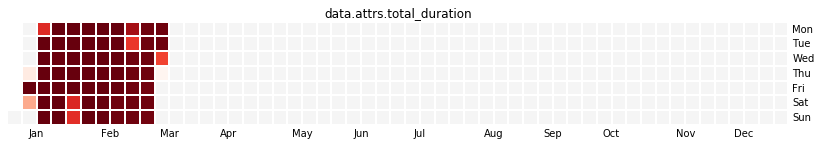

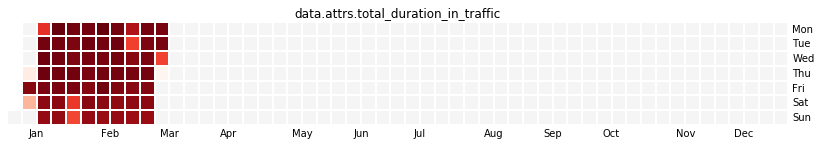

In [24]:
import matplotlib.pyplot as plt
import calmap
import numpy  as np
import pandas as pd
from matplotlib import dates

%matplotlib inline

for feat in features[1:]:
    dev_sr = pd.Series(df[feat].values, index=df["date"])
    plt.figure(figsize=(14,5))
    calmap.yearplot(dev_sr, year=2017)
    plt.title(feat)

In [ ]:
serie = pd.Series(df['data.attrs.delay'].values, index=df["date"])
dd = pd.DataFrame(serie)
dd.reset_index(inplace=True)
dd.head()

In [ ]:
dd = df

In [ ]:
dd = dd.reset_index().groupby(['hour_of_day']).mean()
dd.reset_index(inplace=True)
dd.head()

In [ ]:
dd['day'] = dd['day'].apply(lambda x: datetime.strptime(str(x), '%Y-%M-%d'))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(dd['hour_of_day'], dd['data.attrs.delay'])

In [ ]:
for c in cur_data:
    cur_df[c]['date'] = pd.to_datetime(cur_df[c]['ts']/1000.0, unit='s')

In [ ]:
for f in features :
    for c in cur_df:
        print '-- ', f, ' ', c
        if str(cur_df[c][f].dtype) == "object": continue
        plt.figure(figsize=(14,3))
        plt.title(c)
        plt.plot(cur_df[c]["date"], cur_df[c][f], lw=0.8)
        plt.ylabel(f)
        plt.show()

In [ ]:
train_data = cur_df['cur.zentrum.nibelungenbruecke.traffic.risc-software.at']

In [ ]:
from itertools import chain


for f in features :
    print '-- ', f, ' ', c
    if str(train_data[f].dtype) == "object": 
        train_data[f] = pd.Series(list(chain(*train_data[f].values)))
    plt.figure(figsize=(14,3))
    plt.title(c)
    plt.plot(train_data["date"], train_data[f], lw=0.8)
    plt.ylabel(f)
    plt.show()

In [ ]:
train_data["date"]
train_serie = pd.Series(train_data['data.attrs.delay'].values, 
                        index=train_data["date"])
train_serie.between_time(start_time='01:00', end_time='02:00')

In [ ]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_serie.loc['2017-01-08':'2017-03-04'],lw=1)
plt.plot(train_serie.loc['2017-02-05':'2017-03-04'],lw=1)
plt.ylabel(f)
plt.show()

In [ ]:
def get_precip(gooddate):
    urlstart = 'http://api.wunderground.com/api/0af2503015c7c8fd/history_'
    urlend = '/q/Austria/Linz.json'

    url = urlstart + str(gooddate) + urlend
    data = requests.get(url).json()
    for summary in data['history']['dailysummary']:
        print ','.join((gooddate,summary['date']['year'],
                        summary['date']['mon'],
                        summary['date']['mday'],
                        summary['precipm'], 
                        summary['maxtempm'], 
                        summary['meantempm'],
                        summary['mintempm']))

In [ ]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_serie.loc['2017-02-18':'2017-03-04'],lw=1)
plt.ylabel(f)
plt.show()

In [ ]:
ewma = pd.stats.moments.ewma
EMOV_n = ewma( train_data['data.attrs.delay'] , com=5 )

In [ ]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_data["date"], EMOV_n       , lw=0.8)
plt.plot(train_data["date"], train_data['data.attrs.delay'], lw=0.8)
plt.ylabel(f)
plt.show()

In [ ]:
from pandas.tools.plotting import lag_plot
plt.figure(figsize=(4,4))
lag_plot(train_data['data.attrs.delay'])
plt.show()

In [ ]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(4,4))
autocorrelation_plot(train_data['data.attrs.delay'], lw=0.8)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(4,4))
plot_acf(train_data['data.attrs.delay'], lw=0.8, lags=50)
plt.show()

In [ ]:
values = pd.DataFrame(train_data['data.attrs.delay'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

In [ ]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 4   # number of previous observations to use
h = 1   # forecast horizon
X,y = organize_data(train_data['data.attrs.delay'].values, k, h)

In [ ]:
from sklearn.linear_model import LinearRegression
 
m = 100 # number of samples to take in account
regressor = LinearRegression(normalize=True)
regressor.fit(X[:m], y[:m])

In [ ]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(regressor.predict(X[m:]),y[m:])

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_data['data.attrs.delay'].values, label='True demand', color='#377EB8', linewidth=0.8)
plt.plot(regressor.predict(X),'--', color='#EB3737', linewidth=0.8, label='Prediction')
plt.plot(train_data['data.attrs.delay'].values[:m], label='Train data', color='#3700B8', linewidth=0.8)
plt.legend(loc='upper right')
plt.ylabel('beer consumed (millions of litres)')
plt.show()